# Toy models of SGD for examining the fluctuation-dissipation relations

In [53]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

from IPython.display import clear_output, display

In [Yaida's paper](https://arxiv.org/pdf/1810.00004.pdf), the dynamical system considered is exactly what one would get from SGD updates.  Here $\theta_n$ is the vector of parameters at time-step $n$, and $\mathcal{L}(\theta)$ is the (full-batch) loss function.  At each time-step we sample a mini-batch $b$ from the set of all available batches; practically this corresponds to using the loss function $\mathcal{L}^b(\theta)$.  By definition, the expectation over mini-batches of the gradient of the mini-batch loss function is equal to the gradient of the full-batch loss function.  The update equation reads 
$$ \theta_{n+1} = \theta_n - \eta \frac{\partial \mathcal{L}^b}{\partial \theta} \left( \theta_n \right),$$
where $\eta$ is the learning rate.  Note that this is stochastic because of the random mini-batch which is sampled at each time-step.

Yaida shows that if this dynamical system leads to a steady-state probability distribution, then there are certain relations that must be satisfied by this stationary distribution.

**Status**: Everything matches up nicely for both the quadratic and quartic loss functions now.  It would be fun to look for other interesting situations to apply this to. 

**NOTE**: Some of the things I initially thought when writing this notebook are wrong.  Those are <font color='blue'>left up, in blue color,</font> in the notebook below, with the hope that students reading this in the future can see the error and think through why it is wrong.

## Derivation of the Fluctuation-Dissipation Relations

The derivation of the fluctuation-dissipation relations given in the main text of the paper is pretty clear.  I got stuck on one part of it, so I discuss that here.  

<font color='blue'>
    My initial idea (which was wrong, so in blue):
</font>

<font color='blue'>

Given the update equation at the top, if we had a probability distribution for the parameters $\theta$, we know that if we were to fix the mini-batch number $b$, we would get $\theta \rightarrow \theta - \eta \frac{\partial \mathcal{L}^b}{\partial \theta}(\theta_n)$.  So I thought that the probability distribution at step $n+1$ would be related to the probability distributiona t step $n$ as follows:
$$ p_{n+1}(\theta) = \sum_b p_n\left(\theta + \eta \frac{\partial \mathcal{L}^b}{\partial \theta}(\theta)\right)p_B(b) $$  
</font>

<font color='blue'>

The flaw in this reasoning is that the this tracing back of the evolution evaluated the derivative of the loss function at the 'final' point, whereas actually we should have evaluated it at the previous value of theta.  
</font>

With the above error in mind, the proper relation relating the probability distributions at steps $n+1$ and $n$ is 
$$ p_{n+1}(\theta) = \sum_b p_B(b) \int d\theta' p_n(\theta') \delta(\theta - (\theta' - \eta \frac{\partial \mathcal{L}^b}{\partial \theta}(\theta'))) $$

This implies that if we have a steady-state distribution which is invariant to the transformation above, it must satisfy
$$ p_{SS}(\theta) = \sum_b p_B(b) \int d\theta' p_{SS}(\theta') \delta(\theta - (\theta' - \eta \frac{\partial \mathcal{L}^b}{\partial \theta}(\theta'))) $$
With this in mind we can just follow the derivation in eqn. (6) of the paper.  I find the explicit averaging over the minibatch number $b$ to be easier to follow, but that's a matter of taste. 

## Toy model 1: 1D parabola with two mini-batches

Consider maybe the simplest example of this sort of situation.  Let's make $\theta$ one dimensional, i.e. just a scalar, and let there be two different mini-batches, i.e. $b = 1$ or $b = 2$.  The probability of sampling each batch is $1/2$.  For each batch, the loss function is a parabola centered on $\theta = 1$ (for $b=1$) or $\theta = -1$ (for $b=2$).  Specifically, 
$$ \mathcal{L}^1(\theta) = (\theta - 1)^2$$
$$ \mathcal{L}^2(\theta) = (\theta + 1)^2$$
This leads to the total loss function 
\begin{align}
\mathcal{L}(\theta) & = \frac{1}{2} \left( \mathcal{L}^1(\theta) + \mathcal{L}^2(\theta) \right) \\
& = \theta^2 + 1
\end{align}
Now for the update (SGD) equations.  The derivatives of the mini-batch loss functions are 
$$ (\partial_\theta \mathcal{L}^1)(\theta) = 2(\theta - 1)$$
$$ (\partial_\theta \mathcal{L}^2)(\theta) = 2(\theta + 1)$$
So we have the update equations 
\begin{align}
\theta_{n+1} = \theta_n - 2 \eta \left( \theta_n - 1 \right) & ~~~~~~~~~~~~ \text{(if $b=1$)} \\
\theta_{n+1} = \theta_n - 2 \eta \left( \theta_n + 1 \right) & ~~~~~~~~~~~~ \text{(if $b=2$)} 
\end{align}
This is straightforward to implement in code:

In [77]:
def toy1_transform(theta, eta):
    """ theta is initial value,
        eta is learning rate """
    n_batches = 2
    b = np.random.randint(n_batches)
    if b == 0:
        return theta - 2 * eta * (theta - 1)
    else:
        return theta - 2 * eta * (theta + 1)    

The analysis in Yaida's paper applies only if this system affords a steady-state probaiblity distribution.  Without proving anything, it sure seems like this should have a steady state (unlike the cross-entropy loss mentioned in the paper, there's no way for $\theta$ here to run away to $\infty$, unless maybe the learning rate is too big).  We can play with the system for a bunch of different realizations of the noise to see if there seems to be a steady state distribution.

In [78]:
def final_theta_distribution(n_realizations = 10000,
                             n_steps=300,
                             theta_initial = 0,
                             learning_rate = 0.03,
                             transform_to_use = toy1_transform):
                             
    theta_final = np.zeros(n_realizations)

    for realization in range(n_realizations):
        running_theta = theta_initial # reset theta
        for step_num in range(n_steps):
            running_theta = transform_to_use(running_theta, learning_rate)
        theta_final[realization] = running_theta

    return theta_final

Running this for both several different step numbers, we find: 

In [79]:
# for histogramming later
bins = np.linspace(-1, 1, 100)
bin_centers = (bins[:-1] + bins[1:])/2.

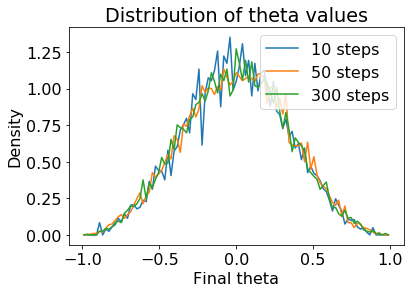

In [80]:
steps_to_test = [10, 50, 300]

test_learning_rate = 0.1

theta_values = {}
histogrammed_thetas = {}

for step_num in steps_to_test:
    theta_values[step_num] = final_theta_distribution(n_steps=step_num,
                                                   n_realizations=10000,
                                                   learning_rate=test_learning_rate)
    histogrammed_thetas[step_num] = np.histogram(theta_values[step_num], bins=bins, density=True)[0]
    plt.plot(bin_centers, histogrammed_thetas[step_num], label=f'{step_num} steps')
    
plt.xlabel(f'Final theta');
plt.ylabel('Density');
plt.legend(loc=1)
plt.title('Distribution of theta values');

Since these distributions are the same, it definitely seems like we have a stationary distribution.  And it also seems like we only need 50 or so steps to acheive this stationary distribution.  So let's look at Yaida's fluctuation relations under this steady state.

### Fluctuation-Dissipation relation 0: $\langle \partial_\theta \mathcal{L}(\theta)\rangle = 0$
In this case, since the derivative of the full-batch loss function is simply proportional to $\theta$, all this relation says is that the expectation of $\theta$ under the stationary distribution is zero.  This seems pretty obvious looking at the distributions plotted above, which look very symmetric.  But just to be sure, we can take means of the final values.

In [81]:
for step_num in steps_to_test:
    print("Mean after {} steps: {}".format(step_num, np.mean(theta_values[step_num])))

Mean after 10 steps: -0.0009381334835200008
Mean after 50 steps: 0.0029886997844019154
Mean after 300 steps: -0.0033160209640836135


Pretty close to zero, so that relation seems happy.

### Fluctuation-Dissipation relation 1: $\langle \theta \cdot \partial_\theta \mathcal{L}(\theta)\rangle = \frac{\eta}{2} \langle C(\theta) \rangle $

All the quantities on the left hand side we have already discussed.  The quantity $C(\theta)$ on the right hand side is related to the noise.  Specifically, it is the gradient covariance, where the ensemble here is the mini-batch.  In this case, that becomes 
$$ C(\theta) = \sum_b p_B(b) \left[ \partial_\theta \mathcal{L}^b(\theta)\right]^2$$ 
(Here there's only one dimension, so the gradient covariance is really just the gradient variance.) Explicitly plugging into the above expression gives 
\begin{align}
C(\theta) & = \frac{1}{2} \left( [2(\theta - 1)]^2 + [2(\theta + 1)]^2 \right)  \\
& = 4(\theta^2 + 1)
\end{align}

So the RHS of of the above equation becomes 
$$ \mathrm{RHS} = 2\eta \langle \theta^2 \rangle + 2\eta $$
And as for the LHS, it is
\begin{align} 
\mathrm{LHS} & = \langle \theta \cdot (2\theta) \rangle  \\
& = 2\langle \theta^2 \rangle 
\end{align}
Setting these two equal to each other gives a relation for the expectation of theta-squared, namely:
$$ \langle \theta^2 \rangle = \frac{\eta}{1 - \eta} $$
Let's check this.

In [82]:
for step_num in steps_to_test:
    print("Mean-squared theta after {} steps: {}".format(step_num, np.mean(np.power(theta_values[step_num], 2))))

Mean-squared theta after 10 steps: 0.10723760244876393
Mean-squared theta after 50 steps: 0.11430854759012024
Mean-squared theta after 300 steps: 0.11184831027482778


Good, so these are the same.  But do they match the formula above?

In [58]:
print("Mean-squared theta according to FDR1: {}".format(test_learning_rate / (1 - test_learning_rate)))

Mean-squared theta according to FDR1: 0.11111111111111112


Not bad!  

### Interlude: Is there a steady state when $\eta > 1$?

Before going on to what the second FDR says, the above relation suggests that if the learning rate is greater than unity, we might not have a sensible steady state.  Let's see if this is true.

In [26]:
theta_final_300_highlr = final_theta_distribution(n_steps=300, learning_rate=1.2)

In [29]:
theta_final_300_highlr

array([ 1.16846103e+44,  1.41403982e+44, -2.12819399e+44, ...,
       -1.89016062e+43, -1.94428379e+44,  1.90105961e+44])

Yep, that looks pretty non-steady-state to me!

### Form of the steady-state probability distribution?

#### TLDR: If the learning rate is small (below roughly 0.03), the steady-state distribution of this system is pretty Gaussian.  Once you go higher in learning rate, this is no longer the case. 

Earlier we saw (from numerics) pretty strong evidence that there was a steady-state probability distribution for the $\theta$ values, at least as long as $\eta < 1$.  And the plots above didn't look too much different from a Gaussian.  Now that we know the the variance of the steady-state distribution (From the fluctuation-dissipation relation 1 above), we can compare the numerically-calculated steady state distribution to a Gaussian of the correct variance to see if they are similar:

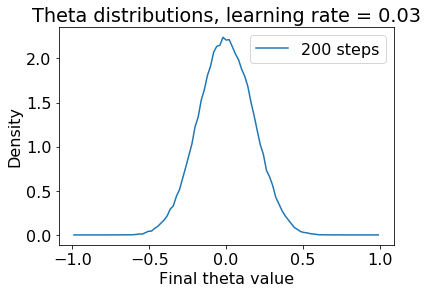

In [84]:
steps_to_test = [200]

test_learning_rate = 0.03

theta_values = {}
histogrammed_thetas = {}

for step_num in steps_to_test:
    
    theta_values[step_num] = final_theta_distribution(n_steps=step_num,
                                                   n_realizations=100000,
                                                   learning_rate=test_learning_rate)
    histogrammed_thetas[step_num] = np.histogram(theta_values[step_num], bins=bins, density=True)[0]
    plt.plot(bin_centers, histogrammed_thetas[step_num], label=f'{step_num} steps')
plt.legend(loc=1)
plt.title("Theta distributions, learning rate = {}".format(test_learning_rate))
plt.xlabel('Final theta value')
plt.ylabel('Density');

If you run the above cell a few times for different values of the learning rate, you should see that for a small learning rate, you get a distribution that seems Gaussian, but for a higher learning rate (try $\eta = 0.2$, for example) you see markedly non-Gaussian behavior.  Using the following cells, we can examine this more closely, overlaying a Gaussian with the actual results.

In [85]:
def expected_variance(learning_rate):
    """ gives the expected variance from the fluctuation-dissipation relation """
    return learning_rate / (1. - learning_rate)

def expected_Gaussian(x, learning_rate):
    var = expected_variance(learning_rate)
    return 1./np.sqrt(2*np.pi*var)*np.exp(-np.power(x,2)/(2*var))

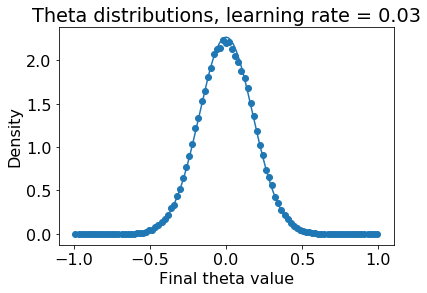

In [86]:
x = np.linspace(-1, 1, 1000)
y = expected_Gaussian(x, test_learning_rate)

plt.scatter(bin_centers, histogrammed_thetas[step_num])
plt.plot(x,y)
plt.title("Theta distributions, learning rate = {}".format(test_learning_rate))
plt.xlabel('Final theta value')
plt.ylabel('Density');

### Fluctuation-Dissipation relation 2: $\langle \left( \partial_\theta \mathcal{L}(\theta) \right) ^2  \rangle = \frac{\eta}{2} \langle \left( \partial_\theta^2 \mathcal{L}(\theta)\right) C(\theta) \rangle $

Note that the FDR2 is normally more complicated than what I've written above, but in the case of a 1D quadratic (our toy model), it reduces to this.  All of the higher-order terms depend on higher derivatives of the loss function, which are zero for a quadratic.  

In our toy case, in fact, it's easy to see that the FDR2 is the same as the FDR1.  Note that $\partial_\theta \mathcal{L}(\theta) = 2\theta$, and $\partial_\theta^2 \mathcal{L}(\theta) = 2$.  So we get that FDR2 is 
\begin{equation}
4 \langle \theta^2 \rangle = \frac{\eta}{2} \langle 2 C(\theta) \rangle,
\end{equation}
which is exactly the same as FDR1.  Note that this is true independent of the mini-batch losses we choose, as long as they all give us the quadratic loss when we perform the averaging.


## Toy model 2: 1D fourth-order loss with two mini-batches

To break one of the toy assumptions of the previous toy model, we make the loss quartic here rather than quadratic.  Again we take two equal-probability mini-batches, which are described by the loss functions
\begin{align}
\mathcal{L}^1 (\theta) & = \left( \theta - 1 \right) ^4 \\
\mathcal{L}^2 (\theta) & = \left( \theta + 1 \right) ^4
\end{align}
This means the total loss function, the average of these two, is given by 
$$ \mathcal{L}(\theta) = \theta^4 + 6\theta^2 + 1 $$
And the gradients of both mini-batch loss functions are 
\begin{align}
\partial_\theta \mathcal{L}^1 (\theta) & = 4 \left( \theta - 1 \right) ^3 \\
\partial_\theta \mathcal{L}^2 (\theta) & = 4 \left( \theta + 1 \right) ^3
\end{align}
So we can write the transform equations like we did before:

In [87]:
def toy2_transform(theta, eta):
    """ theta is initial value,
        eta is learning rate """
    n_batches = 2
    b = np.random.randint(n_batches)
    if b == 0:
        return theta - 4 * eta * np.power(theta - 1, 3)
    else:
        return theta - 4 * eta * np.power(theta + 1, 3)    

And we can get the distribution of final $\theta$ values

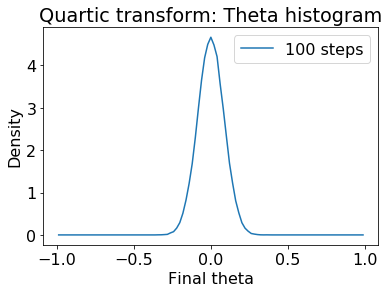

In [88]:
steps_to_test = [100]

test_learning_rate = 0.01

theta_values = {}
histogrammed_thetas = {}

for step_num in steps_to_test:
    theta_values[step_num] = final_theta_distribution(n_steps=step_num,
                                                   n_realizations=100000,
                                                   learning_rate=test_learning_rate,
                                                   transform_to_use=toy2_transform)
    histogrammed_thetas[step_num] = np.histogram(theta_values[step_num], bins=bins, density=True)[0]
    plt.plot(bin_centers, histogrammed_thetas[step_num], label=f'{step_num} steps')
    
plt.xlabel(f'Final theta');
plt.ylabel('Density');
plt.legend(loc=1)
plt.title('Quartic transform: Theta histogram');

Playing around with this for a few different learning rates, it seems like we do settle down to a stationary distribution, as we did before.  Here, however, the condition on the learning rate to have a stationary distribution is different than in the quadratic case.  Specifically, it looks like above maybe 0.06 or 0.07, there is no steady state?  This is surprising.  Maybe we can derive this from some fluctuation-dissipation relations later.

So let's investigate the fluctuation dissipation relations.  

### Fluctuation-Dissipation relation 0:  $\langle \partial_\theta \mathcal{L}(\theta)\rangle = 0$

For this quartic the derivative is given by 
$$\partial_\theta \mathcal{L}(\theta) = 4\theta^3 + 12\theta$$
Just from looking at the distributions above, we can tell that the expectation value of this quantity is going to be zero, since the distribution is symmetric.

In [14]:
step_to_check = steps_to_test[-1]
thetas = theta_values[step_to_check]
loss_derivative = 4*np.power(thetas, 3) + 12*thetas

print('Mean of loss-function derivative after {} steps: {}'.format(step_to_check, np.mean(loss_derivative)))

Mean of loss-function derivative after 100 steps: -0.0029257260591430763


### Fluctuation-Dissipation relation 1: $\langle \theta \cdot \partial_\theta \mathcal{L}(\theta)\rangle = \frac{\eta}{2} \langle C(\theta) \rangle $

Performing the algebra here, we get the ugly relation
$$ \langle \theta^4 + 3\theta^2 \rangle = \eta \left[ \langle (\theta - 1)^6 \rangle + \langle (\theta + 1)^6 \rangle \right]$$

In [15]:
def LHS(theta):
    return np.power(theta, 4) + 3*np.power(theta, 2)
def RHS_without_eta(theta):
    return np.power(theta - 1, 6) + np.power(theta + 1, 6)

We can play around with a couple of different learning rates, by rerunning the cells above, to see whether this relation seems to hold.

In [16]:
np.mean(LHS(thetas))

0.022166980530444753

In [17]:
test_learning_rate*np.mean(RHS_without_eta(thetas))

0.022248511032590085

The agreement here is quite good.  To verify this further, we can make a plot of the LHS and RHS for different values of the learning rate.  

In [71]:
learning_rates = np.linspace(0.01, 0.07, 10)
n_realizations = 10000
n_steps = 100

LHS_stored = np.zeros(len(learning_rates))
RHS_stored = np.zeros(len(learning_rates))

for lr_ind, lr in enumerate(learning_rates):
    clear_output(wait=True); display('Working on learning rate {} of {}'.format(lr_ind, len(learning_rates)))
    current_thetas = final_theta_distribution(n_steps=n_steps,
                                              n_realizations=n_realizations,
                                              learning_rate=lr,
                                              transform_to_use=toy2_transform)
    LHS_stored[lr_ind] = np.mean(LHS(current_thetas))
    RHS_stored[lr_ind] = lr*np.mean(RHS_without_eta(current_thetas))

'Working on learning rate 9 of 10'

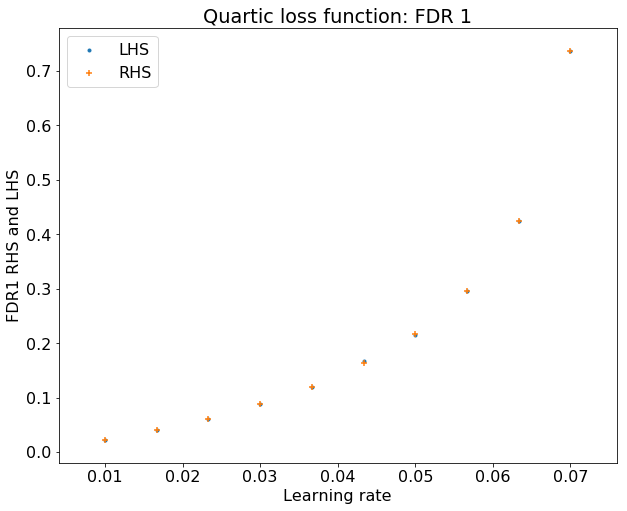

In [72]:
plt.figure(figsize=(10,8))
plt.scatter(learning_rates, LHS_stored, label='LHS', marker='.')
plt.scatter(learning_rates, RHS_stored, label='RHS', marker='+')
plt.xlabel("Learning rate");
plt.ylabel('FDR1 RHS and LHS');
plt.title('Quartic loss function: FDR 1')
plt.legend(loc=2);

### Fluctuation-Dissipation relation 2: $\langle (\partial_\theta \mathcal{L}(\theta))^2\rangle = A\eta + B\eta^2 + C\eta^3 $

(Edit: The paragraph below was my initial expectation, and was wrong, but I'm leaving it up (in blue) so that the studeflaw in the logic, reason that it is wrong, go to [the correct explanation](#correct_explanation) below.)

<font color='blue'>The full fluctuation-dissipation relation 2 given in Yaida's paper (FDR2 below eqn 13) is complicated, but one of its predictions is that for a fourth-order nonlinearity, when we look at steady states, the increase of the expected gradient of the loss, squared, with learning rate (once we have reached stationarity) should be a cubic. We can test this empirically by using several different learning rates, finding the expected derivative squared at stationarity, and then fit this to a cubic.  In order to enforce that the constant term is zero, we will actually fit the function $\langle (\partial_\theta \mathcal{L}(\theta))^2\rangle/\eta$ to a quadratic.</font>

In [20]:
def derivative_squared(theta):
    return np.power(4*np.power(theta, 3) + 12*theta, 2)

In [40]:
n_lrs = 20
learning_rates = np.linspace(0.001, 0.065, n_lrs)

n_steps = 500
n_realizations = 3000

mean_derivative_squared = np.zeros(n_lrs)

thetas = {}

for lr_ind, lr in enumerate(learning_rates):
    clear_output(wait=True); display('Working on lr {} of {} --- eta = {:0.3f}'.format(lr_ind, n_lrs, lr))
    thetas[lr_ind] = final_theta_distribution(n_steps=step_num,
                             n_realizations=n_realizations,
                             learning_rate=lr,
                             transform_to_use=toy2_transform)
    mean_derivative_squared[lr_ind] = np.mean(derivative_squared(thetas[lr_ind]))

'Working on lr 19 of 20 --- eta = 0.065'

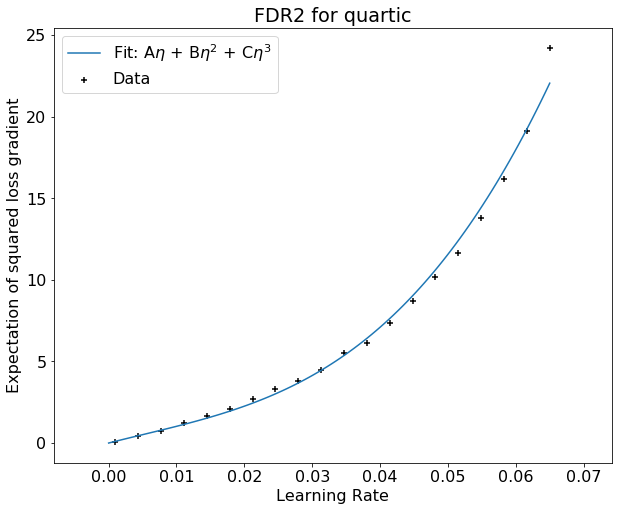

In [59]:
plt.figure(figsize=(10,8))
plt.scatter(learning_rates, mean_derivative_squared, marker='+', color='black', label='Data')

A, B, C = np.polyfit(learning_rates, mean_derivative_squared/learning_rates, deg=2)

x_fit = np.linspace(0, np.max(learning_rates), 100)
plt.plot(x_fit, A*np.power(x_fit, 3) + B*np.power(x_fit, 2) + C*np.power(x_fit,1), label='Fit: A$\eta$ + B$\eta^2$ + C$\eta^3$')
plt.xlabel('Learning Rate')
plt.ylabel('Expectation of squared loss gradient')
plt.title('FDR2 for quartic')
plt.legend(loc=2);

<font color='blue'>The fit seems pretty good, but not exactly perfect.  I wonder if we have not exactly achieved stationarity by this time.  It doesn't look like random noise, i.e. I don't think it's that we're not taking enough realizations, because the residuals look to be very correlated. </font>

<a id='correct_explanation'></a>
**Wrong!! The expectation that this should be a cubic curve was incorrectly bsed on the expectation that the coefficients from the fluctuation-dissipation relation are constant with $\eta$.  They are expectation values of the two-point, three-point, and four-point noise tensors combined with the derivatives of the total loss function.  These obviously depend on the distribution $p_{SS}(\theta)$, which depends on the the learning rate $\eta$.  So, those expectations will also vary with $\eta$.  Bottom line, the whole idea of fitting to a cubic was incorrect.**

We can just calculate what the functional form of the RHS should be.  First, we calculate the derivatives of the total loss function.

\begin{align}
&\mathcal{L}(\theta) &=& \theta^4 + 6\theta^2+1\\
&\partial_\theta \mathcal{L}(\theta) &=& 4\theta^3 + 12\theta\\
&\partial^2\theta \mathcal{L}(\theta) &=& 12\theta^2 + 12\\
&\partial^3\theta \mathcal{L}(\theta) &=& 24 \theta\\
&\partial^4\theta \mathcal{L}(\theta) &=& 24
\end{align}

And then the two, three and four-point noise tensors.  Using the deriatives of the mini-batch loss functions:
\begin{align}
\partial_\theta \mathcal{L}^1 (\theta) & = 4 \left( \theta - 1 \right) ^3 \\
\partial_\theta \mathcal{L}^2 (\theta) & = 4 \left( \theta + 1 \right) ^3
\end{align}

Then the noise tensors become (using notation $C_n$ for the $n$-point noise tensor)
\begin{align}
C_n &= [[ ( \partial_\theta \mathcal{L}^b(\theta) )^n]]_b \\
&= \frac{1}{2} \left( (\partial_\theta \mathcal{L}^1(\theta))^n + (\partial_\theta \mathcal{L}^2(\theta))^n \right) \\
&= \frac{4^n}{2} \left( \left( \theta - 1 \right) ^{3n} + \left( \theta + 1 \right) ^{3n} \right) \\
&= 2^{2n - 1} \left( \left( \theta - 1 \right) ^{3n} + \left( \theta + 1 \right) ^{3n} \right) 
\end{align}

In [23]:
def quartic_noise_tensor(theta, n):
    """ n-point noise tensor of the quartic loss function, evaluated at theta."""
    return np.power(2,2*n-1)*(np.power(theta - 1., 3*n) + np.power(theta + 1., 3*n))

def quartic_loss_derivative(theta, n):
    """ nth partial derivative of the total loss function, evaluated at theta."""
    if n == 0:
        return np.power(theta, 4) + 6*np.power(theta, 2) + 1
    elif n == 1:
        return 4*np.power(theta, 3) + 12*theta
    elif n == 2:
        return 12*np.power(theta, 2) + 12
    elif n == 3:
        return 24*theta
    elif n == 4:
        return 24*np.ones(len(theta))
    elif n >= 5:
        return np.zeros(len(theta))

In [35]:
def quartic_FDR2_RHS(theta, eta):
    """ right-hand side of FDR2 from the paper, for the quartic case"""
    
    return np.sum([quartic_FDR2_RHS_term(theta, eta, k) for k in range(2, 5)])

def quartic_FDR2_RHS_term(theta, eta, k):
    """ gives the term in the RHS of FDR2, specific to the quartic potential,
    which has an eta to the kth power"""
    
    return -1*np.power(-1. * eta, k-1)/np.math.factorial(k) * np.mean(quartic_noise_tensor(theta, k)*quartic_loss_derivative(theta, k))

In [60]:
n_lrs = 20
learning_rates = np.linspace(0.001, 0.065, n_lrs)

n_steps = 500
n_realizations = 3000

mean_derivative_squared = np.zeros(n_lrs)
RHS = np.zeros(n_lrs)

thetas = {}

for lr_ind, lr in enumerate(learning_rates):
    clear_output(wait=True); display('Working on lr {} of {}'.format(lr_ind, n_lrs))
    thetas[lr_ind] = final_theta_distribution(n_steps=step_num,
                             n_realizations=n_realizations,
                             learning_rate=lr,
                             transform_to_use=toy2_transform)
    mean_derivative_squared[lr_ind] = np.mean(derivative_squared(thetas[lr_ind]))
    RHS[lr_ind] = quartic_FDR2_RHS(thetas[lr_ind], lr)

'Working on lr 19 of 20'

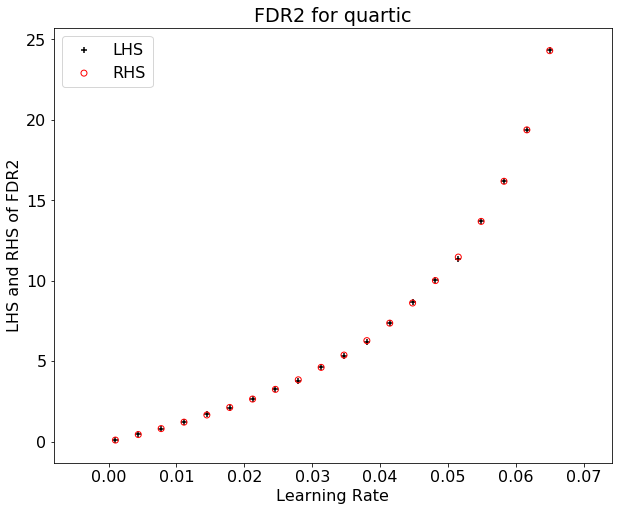

In [70]:
plt.figure(figsize=(10,8))
plt.scatter(learning_rates, mean_derivative_squared, marker='+', color='black', label='LHS')
plt.scatter(learning_rates, RHS, marker='o', color='None', edgecolors='red', label='RHS')

plt.xlabel('Learning Rate')
plt.ylabel('LHS and RHS of FDR2')
plt.title('FDR2 for quartic')
plt.legend(loc=2);

## TODOs

1.  Show that G(eta)/eta is constant for small learning rates for a realistic model, say MNIST with a single-layer network. And when you increase eta and we reach stationarity again, we should get that the expectation of grad f squared goes linearly with the learning rate, for small eta.  See discussion in the paper, section 2.2